In [29]:

# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

# deep learning tools
import tensorflow as tf
from tensorflow import keras

from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
from keras_unet_collection import layer_utils as k_layers
from keras_unet_collection.activations import GELU

sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

def verif_metric(VALID_target, Y_pred, thres=0.5):

    tn, fp, fn, tp = confusion_matrix(VALID_target.ravel(), Y_pred.ravel()>thres).ravel()

    CSI = tp/(tp+fn+fp)
    CSI_metric = 1 - CSI
    
    POFD = fp/(tn+fp)
    
    fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    AUC = auc(fpr, tpr)
    AUC_metric = 1 - AUC
    
    freq = (tp+fp)/(tp+fn)
    freq_metric = np.abs(freq-1.0)
    
    print('{} {} {} {}'.format(CSI, POFD, AUC, freq))
    metric = 0.2*CSI_metric + 0.8*freq_metric


    return metric



In [14]:
# ========== training/validation split ========== #

filename_aug = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch_aug/*.npy"))
filename_full = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch/*.npy"))

cut_train_aug = 136000
cut_train_full = 2848299

filename_train_aug = filename_aug[:cut_train_aug]
filename_train_full = filename_full[:cut_train_full]

factor = 20

L_valid_aug = int(10*factor)
L_valid_full = int(3000*factor)

filename_valid_aug = filename_aug[cut_train_aug:]
filename_valid_full = filename_full[cut_train_full:]

shuffle(filename_valid_aug)
shuffle(filename_valid_full)

filename_valid_aug = filename_aug[-L_valid_aug:]
filename_valid_full = filename_full[-L_valid_full:]

# ========== Validation set ========== #

ind_pick_from_batch = [1, 2, 5, 10, 11, 12, 13, 14, 15, 17]

L_vars = len(ind_pick_from_batch)

grid_shape = (128, 128)

L_valid = L_valid_aug+L_valid_full

VALID_input = np.empty((L_valid,)+grid_shape+(L_vars,))
VALID_target = np.empty(L_valid)

for i, filename in enumerate(filename_valid_aug+filename_valid_full):
    data = np.load(filename)
    
    for c, v in enumerate(ind_pick_from_batch):
    
        VALID_input[i, ..., c] = data[..., v]
        
    if 'pos' in filename:
        VALID_target[i] = True
    elif 'neg' in filename:
        VALID_target[i] = False
    else:
        aergheagtha



In [3]:
# ========== Model ========== #

# ---------- Layers ---------- #

IN = tf.keras.Input((128, 128, 10))

X = IN

X = k_layers.CONV_stack(X, 32, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack1')
X = tf.keras.layers.Conv2D(32, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv1')(X)

X = k_layers.CONV_stack(X, 64, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack2')
X = tf.keras.layers.Conv2D(64, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv2')(X)

X = k_layers.CONV_stack(X, 128, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack3')
X = tf.keras.layers.Conv2D(128, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv3')(X)

X = k_layers.CONV_stack(X, 256, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack4')
X = tf.keras.layers.Conv2D(256, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv4')(X)

X = k_layers.CONV_stack(X, 512, kernel_size=3, stack_num=2, dilation_rate=1, activation='GELU', batch_norm=True, name='conv_stack5')
X = tf.keras.layers.Conv2D(512, kernel_size=2, strides=(2, 2), padding='valid', use_bias=True, name='stride_conv5')(X)

D = tf.keras.layers.Flatten()(X)

D = tf.keras.layers.Dense(512, use_bias=False, name='dense1')(D)
D = tf.keras.layers.BatchNormalization(axis=-1, name='dense_bn1')(D)
D = GELU()(D)

D = tf.keras.layers.Dense(128, use_bias=False, name='dense2')(D)
D = tf.keras.layers.BatchNormalization(axis=-1, name='dense_bn2')(D)
D = GELU()(D)

D = tf.keras.layers.Dense(1, activation='sigmoid', name='head')(D)

OUT = D

model = keras.models.Model(inputs=[IN,], outputs=[OUT,])

W_new = model.get_weights()

# ---------- Weights ---------- #

temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'BIG10'

model_name = '{}_tornado_tune'.format(key)
model_path = temp_dir+model_name
model_path_backup = temp_dir+model_name+'_backup'

#W_new = k_utils.dummy_loader(model_path)

#W_old = k_utils.dummy_loader(temp_dir+'VGG_X_pp20_tune2')
W_new = k_utils.dummy_loader(temp_dir+'BIG10_tornado')
#W_new = k_utils.dummy_loader(model_path)

# for l in range(len(W_old)):
#     if W_old[l].shape == W_new[l].shape:
#         W_new[l] = W_old[l]

# ---------- Compile ---------- #

model.set_weights(W_new)

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=1e-5))



2022-08-22 11:55:05.094021: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-22 11:55:06.317221: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-22 11:55:06.405386: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3e:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-22 11:55:06.407008: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-22 11:55:06.642986: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-22 11:55:06.645091: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

In [ ]:
# # ========== Initial record ========== #

# Y_pred = model.predict([VALID_input,])
# record = verif_metric(VALID_target, Y_pred)
# print('Initial record {}'.format(record))

# # ========== Training hyper parameters ========== #

# tol = 0
# min_del = 0
# max_tol = 500 # early stopping with patience

# epochs = 500
# L_train = 64
# batch_size = 100
# batch_size_half = 50

# valid_size = 1

# X_batch = np.empty((batch_size, 128, 128, L_vars))
# Y_batch = np.empty((batch_size, 1))
# X_batch[...] = np.nan
# Y_batch[...] = np.nan

# # ========== Training loop ========== #

# L_full = len(filename_train_full)
# L_aug = len(filename_train_aug)

# for i in range(epochs):
    
#     if i <= 10:
#         batch_size_full = 70
#     if i > 10 and i <= 35:
#         batch_size_full = 85
#     if i > 35:
#         batch_size_full = 95
    
#     batch_size_aug = batch_size - batch_size_full
    
#     #print('epoch = {}'.format(i))
#     start_time = time.time()
    
#     # loop of batch
#     for j in range(L_train):
        
#         ind_full = du.shuffle_ind(L_full)
#         ind_aug = du.shuffle_ind(L_aug)
        
#         file_pick_full = []
#         for ind_temp in ind_full[:batch_size_full]:
#             file_pick_full.append(filename_train_full[ind_temp])

#         file_pick_aug = []
#         for ind_temp in ind_aug[:batch_size_aug]:
#             file_pick_aug.append(filename_train_aug[ind_temp])
        
#         file_pick = file_pick_full + file_pick_aug
        
#         for k in range(batch_size):
            
#             data = np.load(file_pick[k])
            
#             for c, v in enumerate(ind_pick_from_batch):
                
#                 X_batch[k, ..., c] = data[..., v]
            
#             if 'pos' in file_pick[k]:
#                 Y_batch[k, :] = np.random.uniform(0.95, 0.99)
#             elif 'neg' in file_pick[k]:
#                 Y_batch[k, :] = np.random.uniform(0.01, 0.05)
#             else:
#                 werhgaer
        
#         # # add noise within sparse inputs
#         # for v in flag_sparse:
#         #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

#         # shuffle indices
#         ind_ = du.shuffle_ind(batch_size)
#         X_batch = X_batch[ind_, ...]
#         Y_batch = Y_batch[ind_, :]
        
#         if np.sum(np.isnan(X_batch)) > 0:
#             asfeargagqarew
        
#         # train on batch
#         model.train_on_batch([X_batch,], [Y_batch,]);
    
#     # epoch end operations
#     Y_pred = model.predict([VALID_input,])
#     record_temp = verif_metric(VALID_target, Y_pred, thres=0.7)
    
#     if i % 10 == 0:
#         model.save(model_path_backup)
    
#     if (record - record_temp > min_del) and (np.max(Y_pred) > 0.6):
#         print('Validation loss improved from {} to {}'.format(record, record_temp))
#         record = record_temp
#         tol = 0
#         #print('tol: {}'.format(tol))
#         # save
#         print('save to: {}'.format(model_path))
#         model.save(model_path)
#     else:
#         print('Validation loss {} NOT improved'.format(record_temp))
#         tol += 1
#         #print('tol: {}'.format(tol))
#         if tol >= max_tol:
#             print('Early stopping')
#             sys.exit();
#         else:
#             #print('Pass to the next epoch')
#             continue;
#     print("--- %s seconds ---" % (time.time() - start_time))

In [5]:
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'BIG10'

model_name = '{}_tornado'.format(key)
model_path = temp_dir+model_name

W_new = k_utils.dummy_loader(model_path)

model.set_weights(W_new)

In [15]:
Y_pred = model.predict([VALID_input,])

In [16]:
record_temp = verif_metric(VALID_target, Y_pred, thres=0.7)
Y_pred_label = Y_pred > 0.7

0.33404255319148934 0.004483408056800946 0.9742443883185781 2.1194029850746268


In [19]:
print(classification_report(Y_pred_label.ravel(), VALID_target.ravel()))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     59774
        True       0.78      0.37      0.50       426

    accuracy                           0.99     60200
   macro avg       0.89      0.68      0.75     60200
weighted avg       0.99      0.99      0.99     60200



In [22]:
tn, fp, fn, tp = confusion_matrix(VALID_target.ravel(), Y_pred_label.ravel()).ravel()

In [23]:
CSI = tp/(tp+fn+fp)
print('CSI = {}'.format(CSI))

CSI = 0.33404255319148934


In [27]:
POFD = fp/(tn+fp)
print('Prob. of False Detection = {}'.format(POFD))

Prob. of False Detection = 0.004483408056800946


In [25]:
freq = (tp+fp)/(tp+fn)
print('freq bias = {}'.format(freq))

freq bias = 2.1194029850746268


In [26]:
fpr, tpr, _ = roc_curve(VALID_target.ravel(), Y_pred.ravel())
AUC = auc(fpr, tpr)

print('AUC = {}'.format(AUC))

AUC = 0.9742443883185781


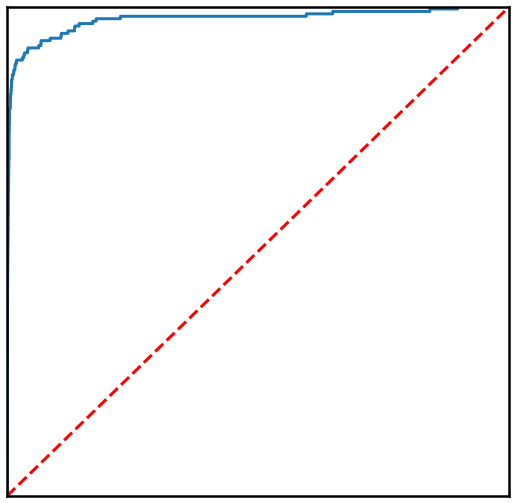

In [30]:
fig = plt.figure(figsize=(9, 9))
ax = fig.gca()
ax = gu.ax_decorate_box(ax)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot(fpr, tpr, lw=3)
ax.plot(fpr, fpr, 'r--', lw=3)